In [1]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
import py7zr
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
    create_train_test_split
)

from super_resolution.src.visualization import plot_gallery

## Loading train and test images

### Windows

In [ ]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("C:/Users/skouf/Documents/2024/STAT3007/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

# train_patches, test_patches = create_train_test_split(
#     str(SITES_DIR) + "\\", sites={"SO2", "FR-BIL", "NARYN"}
# )

train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites={"SO2"}
)

print(
    f"Num train {len(train_patches)}\n"
    f"Num test {len(test_patches)}"
)

### MacOS

In [49]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("/Users/manolis_skoufris/Documents/2024/STAT3007/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "/", sites={'SO2','ES-LTERA'}
)

print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '\\Users\\manolis_skoufris\\Documents\\2024\\STAT3007\\data\\sites'

In [51]:
train_loader = DataLoader(train_patches, batch_size=2)
x_train, y_train = [],[]
for _,(low_res,high_res) in enumerate(train_loader):
    x_train.append(low_res), y_train.append(high_res)

x_train, y_train = torch.cat(x_train), torch.cat(y_train)


test_loader = DataLoader(test_patches, batch_size=2)
x_test, y_test = [],[]
for _,(low_res,high_res) in enumerate(test_loader):
    x_test.append(low_res), y_test.append(high_res)

x_test, y_test = torch.cat(x_test), torch.cat(y_test)

In [122]:
# torch.save(x_train,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_train.pt")
# torch.save(y_train,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_train.pt")
# torch.save(x_test,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_test.pt")
# torch.save(y_test,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_test.pt")

In [2]:
x_train = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_train.pt")
y_train = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_train.pt")
x_test = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_test.pt")
y_test = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_test.pt")
print(x_train.shape)

torch.Size([8159, 3, 128, 128])


## Transformation functions

In [3]:
mean = 0.0
std = 0.0

def normalize(x: torch.tensor):
    means = x.mean(dim=[0,2,3])
    stds = x.std(dim=[0,2,3])

    x_normalized = (x - means[None, :, None, None]) / stds[None, :, None, None]

    # means should be close to 0 while stds should be close to 1.
    # print('Normalized means:', x_normalized.mean(dim=[0, 2, 3]))
    # print('Normalized stds:', x_normalized.std(dim=[0, 2, 3]))
    return x_normalized

def renormalize(x: torch.tensor, means,stds):
    return stds*x + means

In [4]:
def image_transform(x, y):
    x = x[:, :3, :, :]
    y = y[:, :3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [ ]:
x_train, y_train = image_transform(x_train, y_train)
x_test, y_test = image_transform(x_test, y_test)

In [5]:
x_train.shape

torch.Size([8159, 3, 128, 128])

## Plotting example

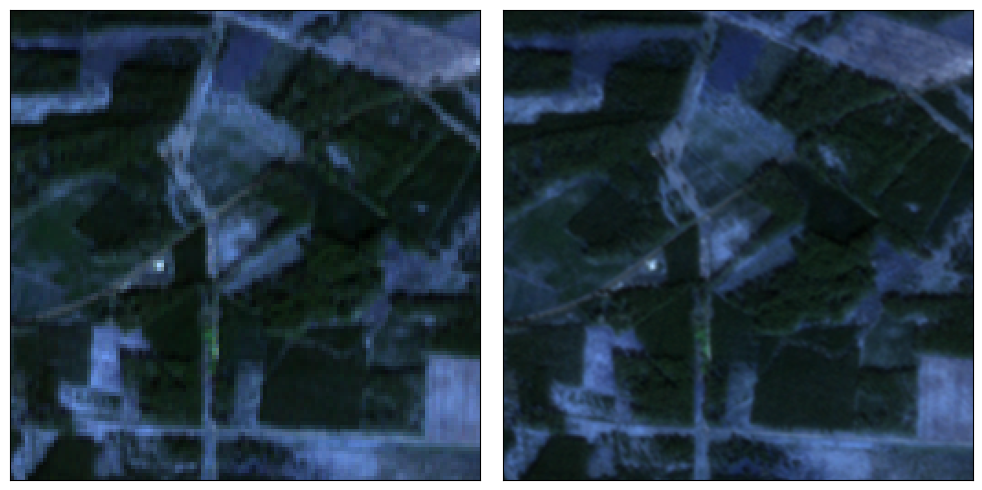

In [6]:
plot_gallery(
    [x_train[2].permute(1,2,0), y_train[2].permute(1,2,0)],
    xscale= 5,
    yscale=5
)

## SRCNN Architecture

In [7]:
class SRCNN(nn.Module):
    """
    A CNN-autoencoder used for super resolution of images, by a factor of 2.
    """
    def __init__(self,f1=9,n1=64,f2=1,n2=32,f3=5,c=3):
        super().__init__()

        # paddings are chosen so that outputs remain the same size
        p1 = (f1 - 1)//2 
        p2 = (f2 - 1)//2
        p3 = (f3 - 1)//2

        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
        self.conv1 = nn.Conv2d(c, n1, f1,padding=p1)
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(n1,n2,f2,padding=p2)
        self.conv3 = nn.Conv2d(n2,c,f3,padding=p3)

        nn.init.normal_(self.conv1.weight, mean=0, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)

        # initialise parameters 
        # self.conv1.weight, self.conv1.bias = nn.Parameter(0.001*torch.randn(n1,c,f1,f1)), nn.Parameter(torch.zeros(n1))
        # self.conv2.weight, self.conv2.bias = nn.Parameter(0.001*torch.randn(n2,n1,f2,f2)), nn.Parameter(torch.zeros(n2))
        # self.conv3.weight, self.conv3.bias = nn.Parameter(0.001*torch.randn(c,n2,f3,f3)), nn.Parameter(torch.zeros(c))

        # self.upscale = nn.Sequential(nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False),
        #                              nn.Conv2d(c, n1, f1,padding=p1),
        #                              nn.ReLU(),
        #                              nn.Conv2d(n1,n2,f2,padding=p2),
        #                              nn.ReLU(),
        #                              nn.Conv2d(n2,c,f3,padding=p3),
        #                              )
    def forward(self,x):
        x = self.upsample(x)
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.conv3(x)
        return x
    
def output_size(N,F,P=0,D=1,S=1):
    return (N + 2*P - D*(F-1)-1)//S + 1

In [8]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[:4].eval())
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[4:9].eval())
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[9:16].eval())
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[16:23].eval())
        
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False # disable gradient computation
        
        self.blocks = nn.ModuleList(blocks)
        
        # self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        # self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def forward(self, x, y,  device, feature_layers = [1], style_layers = [0,1,2,3]):
        loss = 0 
        for i, block in enumerate(self.blocks):
            block = block.to(device)
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += nn.functional.mse_loss(x, y)
                # block = block.cpu()  # Move the block back to CPU after its usage
            if i in style_layers:
                b,c,h,w = x.shape
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1) / (c*h*w)
                gram_y = act_y @ act_y.permute(0, 2, 1) / (c*h*w)
                loss += nn.functional.mse_loss(gram_x, gram_y)
        return loss       

## Training

In [9]:
import torch.optim as optim
# from torch.utils.data import DataLoader
import tqdm
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import peak_signal_noise_ratio
from torchmetrics.functional.image import structural_similarity_index_measure
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class DatasetWrapper(Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.y[idx]

In [10]:
should_pin_memory = {"cuda": True, "cpu": False}

def train(model, x: torch.tensor, y: torch.tensor, lossfunc = nn.MSELoss(), 
          batch_size = 8, nepochs = 10, lr = 10e-4, normalized: bool = True):
    
    losses = []
    epoch_losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # set different learning rates for the layers
    optimizer = optim.Adam(
        [
            {"params": model.conv1.parameters(), "lr": 10e-4},
            {"params": model.conv2.parameters(), "lr": 10e-4},
            {"params": model.conv3.parameters(), "lr": 10e-5}
        ],
        lr=lr)

    if normalized: # normalize inputs
        x = normalize(x)

    # training loop
    dataloader = DataLoader(DatasetWrapper(x,y),
                              shuffle=True,  # Always set to true for training
                              batch_size=batch_size,  # Always try to set as powers of 2
                              drop_last=True  # Ensures batch size is always the one given (Drops last if its is smaller)
                              )
    
    # intialise vgg network 
    vgg = VGGPerceptualLoss().eval()

    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        epoch_loss = 0
        n_batches = 0 
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            n_batches += 1
            optimizer.zero_grad()

            # Move mini-batch data to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # forward pass through the CNN
            out = model.forward(x_batch)
            
            # compute perceptuual loss
            loss = vgg.forward(out, y_batch, feature_layers=[0,1,2,3],style_layers=[], device = device)

            # loss = lossfunc(out, y_batch)
            epoch_loss += loss.item()
            losses.append(loss.item())

            # gradient descent 
            loss.backward()
            optimizer.step()

        
        epoch_losses.append(epoch_loss)  
        epoch_loss /= n_batches
        loop.set_postfix(loss="%5.5f" % (epoch_loss)) 

    return losses, epoch_losses

def test(model, x: torch.tensor, y: torch.tensor, batch_size = 64, lossfunc = nn.MSELoss()):
    with torch.no_grad(): # disable automatic gradient computation for efficiency
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        loss = 0
        n_batches = 0
        
        dataloader = DataLoader(DatasetWrapper(x,y),
                                shuffle=False,  # Set to false for testing
                                batch_size=batch_size,  # Always try to set as powers of 2
                                drop_last=True  # Ensures batch size is always the one given (Drops last if its is smaller) 
                                )
        
        for x_batch, y_batch in dataloader:
            n_batches += 1
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model.forward(x_batch)
            loss += lossfunc(out, y_batch)
    
        return (1/n_batches)*loss
    

In [12]:
torch.manual_seed(1)
model_vgg_best = SRCNN(f2=3)
torch.cuda.empty_cache()

# max batch size is 32 
losses, epoch_losses = train(model_vgg_best, x_train, y_train, nepochs=100, batch_size = 32, lr = 10e-5, normalized=False)

  0%|                                                                                 | 0/100 [00:00<?, ?it/s]c:\Users\skouf\Documents\2024\STAT3007\stat3007-project\myenv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████████████████████████████████████████████████| 100/100 [6:37:04<00:00, 238.25s/it, loss=0.06419]


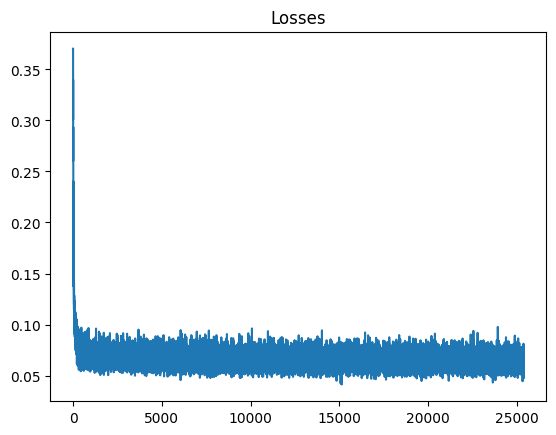

In [36]:
plt.plot(losses)
plt.title("Losses")
plt.savefig("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/figures/2nd_best_losses.png")

In [19]:
torch.save(model_vgg_best,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model_vggloss_best.pt")

In [61]:
model_vgg = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model.pt")

In [24]:
print(f"Train set accuracy: {test(model_vgg_best, x_train, y_train):.4f}")
print(f"Test set accuracy: {test(model_vgg_best, x_test, y_test):.4f}")

KeyboardInterrupt: 

## Plotting predictions 

In [26]:
means = y_train.mean(dim=[0,2,3])
stds = y_train.std(dim=[0,2,3])
means, stds = means[None, :, None, None],stds[None, :, None, None]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


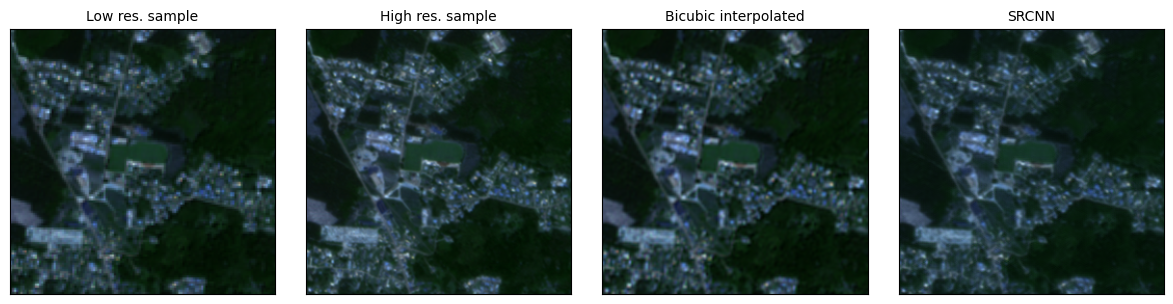

In [32]:
i = 4
o = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(x_train[5000:5010])
out = model_vgg_best.forward(x_train[5000:5010].to(torch.device("cuda")))
# plot_gallery(
#     [x_train[i].permute(1,2,0),
#     y_train[i].permute(1,2,0),
#     o[i].permute(1,2,0), 
#     out[i].cpu().detach().permute(1,2,0)],
#     xscale=3,
#     yscale=3,
#     titles =
#     ["Low res. sample", 
#      "High res. sample",
#      "Bicubic interpolated",
#      "SRCNN"],
#      output="C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/figures/vgg_loss_sample.png"
# )

plot_gallery(
    [x_train[5000:5010][i].permute(1,2,0),
    y_train[5000:5010][i].permute(1,2,0),
    o[i].permute(1,2,0), 
    out[i].cpu().detach().permute(1,2,0)],
    xscale=3,
    yscale=3,
    titles =
    ["Low res. sample", 
     "High res. sample",
     "Bicubic interpolated",
     "SRCNN"],
     output="C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/figures/vgg_loss_with_feature_layers_sample_test.png"
)

## Metrics

In [16]:
from dataclasses import dataclass
@dataclass
class Metrics:
    """Super-resolution metrics"""

    mse: float
    psnr: float
    ssim: float

    def print_metrics(self):
        print(f"MSE:{self.mse:.4f}", "\n", f"SSIM:{self.ssim:.4f}", "\n", f"PSNR:{self.psnr:.4f}","\n")


def compute_metrics(super_resolver, x: torch.tensor, y: torch.tensor, batch_size = 32):
    with torch.no_grad(): # disable automatic gradient computation for efficiency
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super_resolver.to(device)
        mean_psnr = 0.0
        mean_ssim = 0.0
        mean_mse = 0.0

        loader = DataLoader(DatasetWrapper(x,y),
                                shuffle=False,  # Set to false for testing
                                batch_size=batch_size,  # Always try to set as powers of 2
                                drop_last=True  # Ensures batch size is always the one given (Drops last if its is smaller) 
                                )
        
        for low_res, high_res in loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            super_resolved = super_resolver(low_res)

            mean_mse += nn.MSELoss()(super_resolved, high_res)
            mean_psnr += peak_signal_noise_ratio(super_resolved, high_res, 1.0).item()
            ssim = structural_similarity_index_measure(
                super_resolved, high_res, data_range=(0.0, 1.0)
            )
            assert isinstance(ssim, torch.Tensor)
            mean_ssim += ssim.item()

        mean_mse /= len(loader)
        mean_ssim /= len(loader)
        mean_psnr /= len(loader)    
        return Metrics(mean_mse, mean_ssim, mean_psnr)

In [26]:
print("SRCNN metrics:")
compute_metrics(model_vgg_best,x_test,y_test).print_metrics()

print("Bicubic interpolation metrics:")
compute_metrics(nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False), x_test,y_test).print_metrics()

SRCNN metrics:
MSE:0.0011 
 SSIM:29.7172 
 PSNR:0.9129 

Bicubic interpolation metrics:
MSE:0.0012 
 SSIM:29.3306 
 PSNR:0.9075 

